# 3D Curl Curl problem -- STILL BROKEN
The purpose of this notebook is to solve the Curl Curl equation in 3D using a primal formulation, and then improving the order of convergence by post-processing: 

We solve $\operatorname{curl}\operatorname{curl}u = f$ weakly: 
$$\int(\operatorname{curl}\operatorname{curl}u)\cdot v=\int f\cdot v~~\forall v\in V_h$$
Taking the weak form of the above equation (in this case, using the vector 
identity $(\nabla\times A)\cdot B = \nabla\cdot(A\times B) + (\nabla\times B)\cdot A$ where $A=\nabla\times u$ and 
$B=v$) we get
$$
\int_\Omega(\operatorname{curl}u)\cdot(\operatorname{curl}v) + \operatorname{div}((\operatorname{curl}u)\times v) = \int_\Omega f\cdot v
$$
In order to insure uniqueness (recall that the nullspace of the curl operator contains the image of the gradient operator), we instead solve the modified equation for 
$(u, \sigma)\in H(\operatorname{curl})\times H^1$ where: 

$$\begin{array}{rcl}
    \int_\Omega\operatorname{curl}u\cdot\operatorname{curl}v +
        \int_{\partial\Omega} (\operatorname{curl}u)\times v \cdot n + 
        \int_\Omega v\cdot\operatorname{grad}\sigma &=& \int_\Omega f\cdot v\\
    \int_\Omega u\cdot\operatorname{grad}\tau &=& 0 
\end{array}~~\forall (v,\tau)\in H(\operatorname{curl})\times H^1$$

Note that the values for the example problem used below were generated using the auxiliary script generate_3d_curl_vals.py

In [1]:
from dolfin import *
import numpy as np
import matplotlib.pyplot as plt
#%config InlineBackend.figure_format = 'retina'

In [27]:
def errors_3d(n, r=1):
    
    mesh = UnitCubeMesh(n, n, n)
    # start by solving for u using non-hybrid method

    S_element = FiniteElement('CG', mesh.ufl_cell(), r+1)
    V_element = FiniteElement('N2curl', mesh.ufl_cell(), r)
    W = FunctionSpace(mesh, S_element*V_element)
    
    bcs = [DirichletBC(W.sub(0), Constant(0), DomainBoundary()),
           DirichletBC(W.sub(1), Constant((0,0,0)), DomainBoundary())]

    N = FacetNormal(mesh)
    s, u = TrialFunctions(W)
    t, v = TestFunctions(W) 

    a = (inner(curl(u), curl(v)) + inner(grad(s), v) + inner(grad(t), u) - inner(s,t))*dx - \
        (inner(cross(curl(u), v), N))*ds
    f = Expression(("pow(pi, 2)*(sin(pi*x[0])*sin(pi*x[1]) + cos(pi*x[0])*cos(pi*x[2]))",
                    "pow(pi, 2)*(sin(pi*x[1])*sin(pi*x[2]) + cos(pi*x[0])*cos(pi*x[1]))",
                    "pow(pi, 2)*(sin(pi*x[0])*sin(pi*x[2]) + cos(pi*x[1])*cos(pi*x[2]))"), degree=r+1)
    L = inner(f, v)*dx
    
    w = Function(W)
    solve(a == L, w, bcs=bcs)
    u = w.sub(1)
    
    curl_u = project(curl(u), VectorFunctionSpace(mesh, "DG", r-1))
    
    # post-process
    """
    V_dg_element = VectorElement('DG', mesh.ufl_cell(), r)
    Q_element = VectorElement('CG', mesh.ufl_cell(), r+2)
    W = FunctionSpace(mesh, V_dg_element*Q_element)
    
    lam, q = TrialFunctions(W)
    v, p = TestFunctions(W)
    a = (inner(q, p) + inner(curl(q), curl(p)))*dx + \
        (inner(q, cross(v, N)) + inner(p, cross(lam, N)))*dS
    L = (inner(f, v + curl(p)) + inner(curl_u, p + curl(v)))*dx
    
    w = Function(W)
    solve(a == L, w)
    q = w.sub(1)
    """

    # exact solutions
    u_exact = Expression(("sin(pi*x[0])*sin(pi*x[1])",
                          "sin(pi*x[1])*sin(pi*x[2])",
                          "sin(pi*x[0])*sin(pi*x[2])"), degree=r+3)
    curl_u_exact = Expression(("pi*(-sin(pi*x[1])*cos(pi*x[2]))",
                               "pi*(-sin(pi*x[2])*cos(pi*x[0]))",
                               "pi*(-sin(pi*x[0])*cos(pi*x[1]))"), degree=r+5)

    u_error = errornorm(u_exact, u)
    curl_u_error = errornorm(curl_u_exact, curl_u)
    q_error = 1#errornorm(curl_u_exact, q)

    """
    File("3d_u_exact_n=%d.pvd"%n) << project(u_exact, FunctionSpace(mesh, "N2curl", r))
    File("3d_u_n=%d.pvd"%n) << u
    File("3d_curl_u_n=%d.pvd"%n) << curl_u
    File("3d_curl_u_exact_n=%d.pvd"%n) << project(curl_u_exact, VectorFunctionSpace(mesh, "CG", r+2))
    """

    return u_error, curl_u_error, q_error

In [28]:
ns = [2**k for k in range(1,3)]
es_3d = [errors_3d(n, r=2) for n in ns]

## Examine error & convergence rates

Text(0, 0.5, 'error')

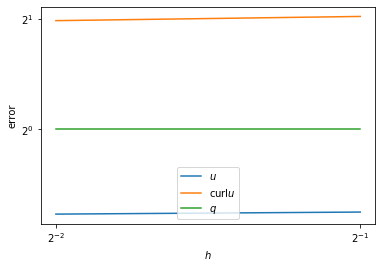

In [29]:
plt.loglog(1/np.array(ns), es_3d, basex=2, basey=2)
plt.legend(['$u$',r'$\operatorname{curl} u$','$q$'])
plt.xlabel('$h$')
plt.ylabel('error')

In [30]:
rates = -np.diff(np.log2(es_3d), axis=0)
rates

array([[ 0.01859217,  0.03809638, -0.        ]])

In [31]:
es_3d

[(0.5952326838000391, 2.0316402367492126, 1),
 (0.5876110723648019, 1.9786940765764565, 1)]